In [2]:
%pip install pip tqdm numpy torch torchvision matplotlib scikit-learn torchinfo --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import random as rd
from tqdm import tqdm

# if torch.backends.mps.is_available():
#     torch.set_default_device("mps")

In [8]:
t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.49186864, 0.48265335, 0.44717798),
            std=(0.24697131, 0.24338901, 0.26159254),
        ),
    ]
)

train_dataset = datasets.CIFAR10(root="./data", download=True, train=True, transform=t)
test_dataset = datasets.CIFAR10(root="./data", download=True, train=False, transform=t)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
len(train_dataset + test_dataset)

60000

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=True)

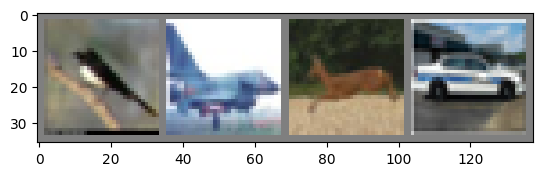

bird  plane deer  car  


In [11]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
for i, (X_train_tensor, y_train_tensor) in enumerate(train_loader):
    print(i, X_train_tensor.shape, y_train_tensor.shape)
    break

0 torch.Size([4, 3, 32, 32]) torch.Size([4])


In [4]:
# Define the MLP architecture
class CIFAR_Convo(nn.Module):
    def __init__(self):
        super(CIFAR_Convo, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=5,
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc_lyr1 = nn.Linear(16 * 6 * 6, 128)
        self.fc_lyr2 = nn.Linear(128, 64)
        self.fc_lyr3 = nn.Linear(64, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        out = F.relu(self.conv2(out))
        out = self.pool(out)
        # out = out.reshape(out.size(0), -1)
        out = torch.flatten(out, 1)
        out = F.relu(self.fc_lyr1(out))
        out = F.relu(self.fc_lyr2(out))
        out = self.fc_lyr3(out)

        return out

In [5]:
# Create an instance of the MLP model
model = CIFAR_Convo()
# model = torch.load("./models/cifar10_1699471134_99E_model.pt")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [31]:
summary(model, input_size=(4, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR_Convo                              [4, 10]                   --
├─Conv2d: 1-1                            [4, 6, 30, 30]            456
├─MaxPool2d: 1-2                         [4, 6, 15, 15]            --
├─Conv2d: 1-3                            [4, 16, 13, 13]           2,416
├─MaxPool2d: 1-4                         [4, 16, 6, 6]             --
├─Linear: 1-5                            [4, 128]                  73,856
├─Linear: 1-6                            [4, 64]                   8,256
├─Linear: 1-7                            [4, 10]                   650
Total params: 85,634
Trainable params: 85,634
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.61
Input size (MB): 0.05
Forward/backward pass size (MB): 0.27
Params size (MB): 0.34
Estimated Total Size (MB): 0.66

In [88]:
loss_ar = []

In [89]:
# Train the model
model.train()
epoch = 2

for epoch in (pbar:= tqdm(range(epoch))):
    for i, (X_train_tensor, y_train_tensor) in enumerate(train_loader):
        # Forward pass: Get predictions
        y_pred = model(X_train_tensor)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_train_tensor)
        loss_ar.append(loss.item())

        pbar.set_postfix_str(f"Loss: {loss.item()}")
        
        # Zero grad
        optimizer.zero_grad()

        # Backward pass
        loss.backward()
        optimizer.step()

100%|██████████| 2/2 [01:13<00:00, 36.90s/it, Loss: 1.119035005569458]  


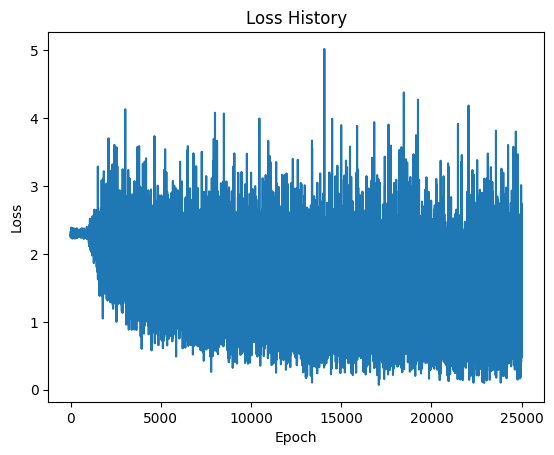

In [90]:
# Plotting the loss history
plt.plot(loss_ar)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [47]:
torch.save(model, 'model.pt')

# Run a test using predefined values

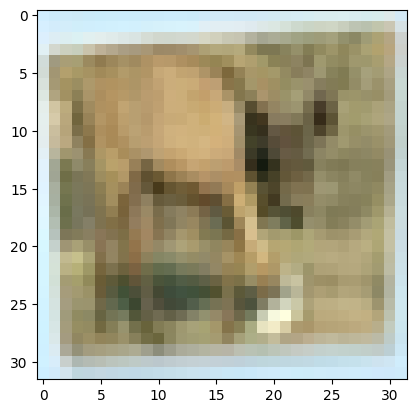

deer


[('cat', 21.33033275604248),
 ('ship', 15.16420841217041),
 ('car', 12.748712301254272),
 ('frog', 12.246301025152206),
 ('truck', 9.90241914987564),
 ('plane', 8.464040607213974),
 ('dog', 7.756631821393967),
 ('horse', 4.847782850265503),
 ('deer', 3.830518200993538),
 ('bird', 3.7090495228767395)]

In [33]:
d = test_dataset
X_input_indx = rd.randint(0, len(d))

image, label = d[X_input_indx]
imshow(image) # from previous cell
print(classes[label]) # from previous cell

X_final = image.unsqueeze(0)

model.eval()
output = (model(X_final) ** 2).sqrt().squeeze()

o = {}
for i in range(10):
    o[classes[i]] = (output / output.sum())[i].item() * 100

sorted(o.items(), key=lambda x: x[1], reverse=True)

In [46]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

check_accuracy(loader=train_loader, model=model)
check_accuracy(loader=test_loader, model=model)

Got 6246 / 10000 with accuracy 62.46
Got 45133 / 50000 with accuracy 90.27
